In [1]:
!pip install torchify

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,f1_score,precision_score
from torchvision import transforms as tt
from torchvision import datasets

In [15]:
train_ds = datasets.CIFAR10(root='./data', train=True, download=True,transform=tt.ToTensor())
test_ds = datasets.CIFAR10(root='./data', train=False, download=True,transform=tt.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [16]:
train_dl=DataLoader(train_ds,batch_size=32,shuffle=True)
test_dl=DataLoader(test_ds,batch_size=32,shuffle=False)

In [17]:
from Torchify.VisionNet import ImageModel

In [18]:
class Model(ImageModel):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(3,6,5,1)
        self.conv2=nn.Conv2d(6,16,3,1)
        self.fc1=nn.Linear(6*6*16,120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,10)

    def forward(self,X):
        X=F.relu(self.conv1(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv2(X))
        X=F.max_pool2d(X,2,2)
        X=X.view(-1,6*6*16)
        X=F.relu(self.fc1(X))
        X=F.relu(self.fc2(X))
        X=self.fc3(X)

        return F.log_softmax(X,dim=1)

In [19]:
lr=0.001
wd=1e-4
gc=0.1
epochs=10

In [20]:
model=Model()

In [21]:
loss=nn.CrossEntropyLoss()
optimizer=torch.optim.AdamW(model.parameters(),lr=lr,weight_decay=wd)
sched=torch.optim.lr_scheduler.OneCycleLR(optimizer,lr,epochs=epochs,steps_per_epoch=len(train_dl))

In [22]:
model.compile(loss_fn=loss,
              optimizer=optimizer,
              scheduler=sched,
              grad_clip=gc)

In [23]:
import time
start=time.time()

history=model.fit(epochs=epochs,
                  train_loader=train_dl,
                  val_loader=test_dl)

print(f'Training time: {(time.time()-start)/60} minutes')

Training on cuda
Epoch [1], train_loss: 2.0650, train_acc: 0.2404, val_loss: 1.8491, val_acc: 0.3200
Epoch [2], train_loss: 1.6380, train_acc: 0.4030, val_loss: 1.5369, val_acc: 0.4380
Epoch [3], train_loss: 1.4562, train_acc: 0.4732, val_loss: 1.4585, val_acc: 0.4752
Epoch [4], train_loss: 1.3371, train_acc: 0.5186, val_loss: 1.3369, val_acc: 0.5205
Epoch [5], train_loss: 1.2358, train_acc: 0.5597, val_loss: 1.2075, val_acc: 0.5721
Epoch [6], train_loss: 1.1463, train_acc: 0.5932, val_loss: 1.1647, val_acc: 0.5850
Epoch [7], train_loss: 1.0664, train_acc: 0.6223, val_loss: 1.1233, val_acc: 0.6012
Epoch [8], train_loss: 0.9950, train_acc: 0.6491, val_loss: 1.1031, val_acc: 0.6124
Epoch [9], train_loss: 0.9427, train_acc: 0.6686, val_loss: 1.0851, val_acc: 0.6203
Epoch [10], train_loss: 0.9157, train_acc: 0.6778, val_loss: 1.0821, val_acc: 0.6212
Training time: 2.3300923109054565 minutes


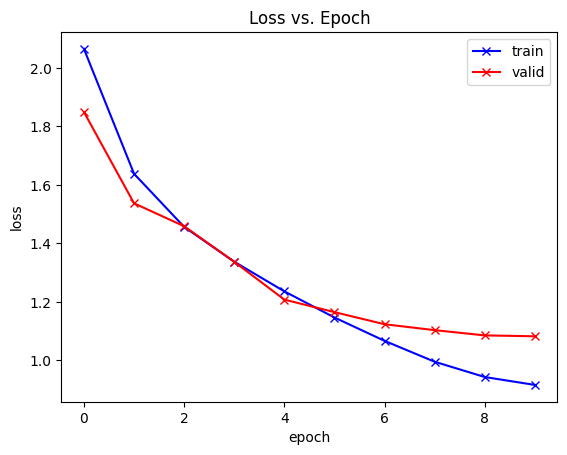

In [24]:
model.plot_losses()

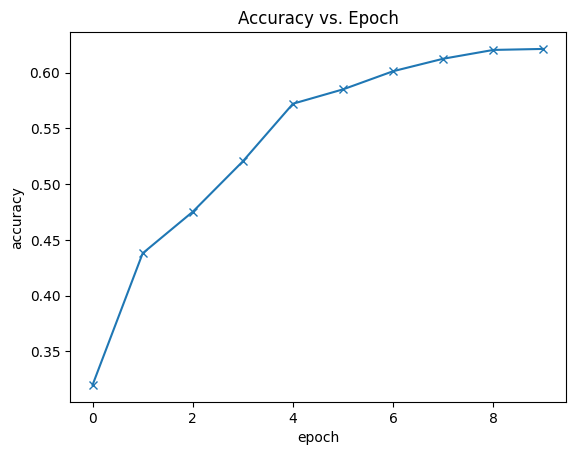

In [25]:
model.plot_accuracies()

In [26]:
model.evaluate(test_dl)

{'val_loss': 1.0820668935775757, 'val_acc': 0.6212060451507568}

In [27]:
model.metrics(test_ds)

(0.6211, 0.6187369860946041, 0.6175686935093683)